In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20000)
pd.options.mode.chained_assignment = None #Ignore Error: SettingWithCopyWarning
import math
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import os
import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

keras.backend.clear_session()

# Load the data

In [2]:
#df = pd.read_csv('../data/preprocessed/cleaned_data_v7.csv', delimiter=",")
df = pd.read_csv('../data/preprocessed/cleaned_data_v8.csv', delimiter=",")

key_list = df.keys().tolist()

for x in range(len(key_list)):
    if not df.columns[x] == "datum":
        if not df.columns[x] == "container_id":
            df = df.astype({key_list[x]: "float32"})

# Delete unwanted data; cast datetime

In [3]:
df = df.drop(columns=["height_in_cm"])

# set date as index ancd convert to float
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index(df['datum'])
df = df.sort_index()
df['datum_float'] = df['datum'].values.astype(float)

# Split into train/test

In [4]:
# create train test partition
training_set = df['2020-05-09 00:00:00':'2021-01-29 23:59:59']
test_set  = df['2021-01-30 00:00:00':]
container_number = 1
training_set = training_set[training_set['container_id']==container_number]
test_set = test_set[test_set['container_id']==container_number]
print('Train Dataset:',training_set.shape)
print('Test Dataset:',test_set.shape)

Train Dataset: (5501, 25)
Test Dataset: (1805, 25)


In [5]:
y_training_set = pd.DataFrame(training_set["hight_delta"].values.tolist(), columns=["hight_delta"])
training_set = training_set.drop(columns=["hight_delta", "datum"])
####
y_test_set = pd.DataFrame(test_set["hight_delta"].values.tolist(), columns=["hight_delta"])
test_set = test_set.drop(columns=["hight_delta", "datum"])

In [6]:
training_set.keys()

Index(['container_id', 'temperatur_in_grad', 'aussentemperatur',
       'niederschlag_in_mm', 'ist_industriegebiet', 'ist_wohngebiet',
       'ist_feiertag', 'sekunde', 'minute', 'stunde', 'wochentag',
       'kalenderwoche', 'monat', 'jahr', 'farbe_brown', 'farbe_green',
       'farbe_white', 'unix_time', 'time_delta', 'ist_ferien', 'laengengrad',
       'breitengrad', 'datum_float'],
      dtype='object')

# Prepare the training data

In [7]:
#https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
#https://analyticsindiamag.com/hands-on-guide-to-lstm-recurrent-neural-network-for-stock-market-prediction/
# Feature Scaling

# ****************** START TUNING *************
timelag = 6 #10
epochs_number = 200 #10
batch_size_number = 16 #32


# ****************** END TUNING *************

train_set = training_set.iloc[:,:].values
y_train_set = y_training_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
sc1 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
y_train_set_scaled = sc1.fit_transform(y_train_set)

X_train = []
y_train = []
for i in range(timelag, len(training_set)-1):
    X_train.append(training_set_scaled[i-timelag:i, :])
    y_train.append(y_train_set_scaled[i-1, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
y_train_set_scaled[2]

array([1.])

# Configure the model

In [9]:
dropout = 0.2
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = X_train[0].shape))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(dropout))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(dropout))
# regressor.add(Dense(units = 25))
# regressor.add(Dropout(dropout))
regressor.add(Dense(units = 1))

#first callback method
reduce_lr = ReduceLROnPlateau(monitor="mean_squared_error", factor=0.1, verbose=1,
patience=100, min_lr=0.0000001)
#default value lr = 0.001
# callbacks = [reduce_lr]

def lr_sched(epoch, current_lr):
    if epoch == 700:
        print("Reduced learningrate from " + str(current_lr))
        current_lr = current_lr * 0.1
        print("To learningrate  " + str(current_lr))
    return current_lr

change_lr = LearningRateScheduler(lr_sched)
callbacks = [change_lr]

# Second callback mehod
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model

In [10]:
regressor.compile(optimizer = 'adam', loss = 'mse', metrics=["mae"])
history = regressor.fit(X_train, y_train, epochs = epochs_number, batch_size = batch_size_number
#                         , callbacks=callbacks
                       )
#, callbacks = callbacks
# callbacks=[es_callback]
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

Epoch 1/200
344/344 [==============================] - 29s 19ms/step - loss: 0.1463 - mae: 0.2365
Epoch 2/200
344/344 [==============================] - 7s 19ms/step - loss: 0.0087 - mae: 0.0711
Epoch 3/200
344/344 [==============================] - 6s 19ms/step - loss: 0.0078 - mae: 0.0658
Epoch 4/200
344/344 [==============================] - 7s 19ms/step - loss: 0.0081 - mae: 0.0686
Epoch 5/200
344/344 [==============================] - 6s 19ms/step - loss: 0.0076 - mae: 0.0641
Epoch 6/200
344/344 [==============================] - 7s 19ms/step - loss: 0.0069 - mae: 0.0620
Epoch 7/200
344/344 [==============================] - 6s 19ms/step - loss: 0.0066 - mae: 0.0602
Epoch 8/200
344/344 [==============================] - 6s 19ms/step - loss: 0.0062 - mae: 0.0577
Epoch 9/200
344/344 [==============================] - 7s 19ms/step - loss: 0.0062 - mae: 0.0564
Epoch 10/200
344/344 [==============================] - 6s 19ms/step - loss: 0.0061 - mae: 0.0551
Epoch 11/200
344/344 [======

KeyboardInterrupt: 

# Prepare the test data

In [11]:
test_set = test_set.iloc[:,:].values
y_test_set = y_test_set.iloc[:,:].values

sc = MinMaxScaler(feature_range = (0, 1))
test_set_scaled = sc.fit_transform(test_set)

Y_test = []
X_test = []
for i in range(timelag, len(test_set)-1):
    X_test.append(test_set_scaled[i-timelag:i, :])
    Y_test.append(y_test_set[i-1,0])
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [12]:
X_test.shape

(1798, 6, 23)

# Predict

In [13]:
predicted_height = regressor.predict(X_test)
predicted_height = sc1.inverse_transform(predicted_height)

# Plot the prediction

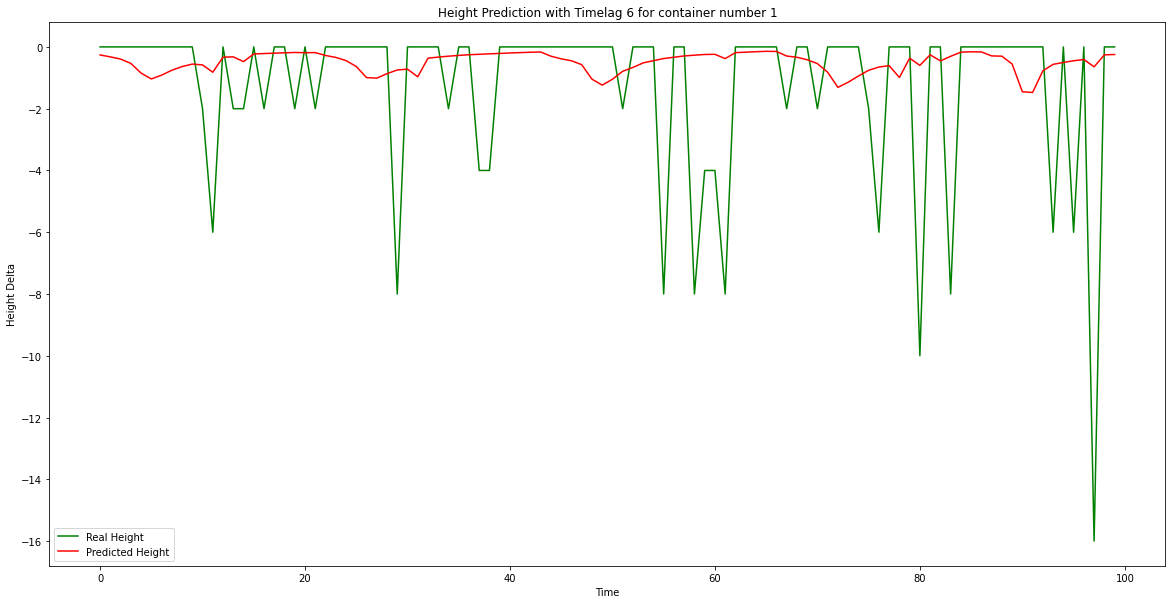

In [15]:
plt.figure(figsize=(20,10))
plt.plot(y_test_set[:100], color = 'green', label = 'Real Height')
plt.plot(predicted_height[:100], color = 'red', label = 'Predicted Height')
plt.title('Height Prediction with Timelag '+ str(timelag) + ' for container number ' +str(container_number))
plt.xlabel('Time')
plt.ylabel('Height Delta')
plt.legend()
plt.show()

# Export Model

In [ ]:
regressor.save('../data/modeling/dev/test_model')

# TEST FOR A SINGLE PREDICTION

In [ ]:
# reconstructed_model = keras.models.load_model("../data/modeling/dev/test_model")

In [ ]:
# test_set_sub = test_set[test_set['container_id']==1].head(1)
# training_set_sub = training_set[training_set['container_id']==1]

# real_height = test_set_sub.iloc[:, 20:21].values
# dataset_total = pd.concat((training_set_sub['hight_delta'], test_set_sub['hight_delta']), axis = 0)
# inputs = dataset_total[len(dataset_total) - len(test_set_sub) - timelag:].values
# inputs = inputs.reshape(-1,1)
# inputs = sc.transform(inputs)
# X_test = []
# for i in range(timelag, len(test_set_sub)+timelag):
#     X_test.append(inputs[i-timelag:i, 0])
# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predicted_height = reconstructed_model.predict(X_test)
# predicted_height = sc.inverse_transform(predicted_height)

# print("Pred ="+str(predicted_height)+" and real height = "+str(real_height))

In [ ]:
# test_set_sub